## Spatial Segregation and Clustering Indices

Contributors: Arezoo Besharati-Zadeh and Paul Waddell

This notebook covers several methods used to compute patterns of spatial segregation and clustering.  A good resource for the metrics computed here is https://www.census.gov/hhes/www/housing/resseg/pdf/app_b.pdf

In [1]:
%matplotlib inline

import math 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

In [3]:
# See what's in the data file 
with pd.HDFStore('data/model_data.h5') as test:
    print (test)

<class 'pandas.io.pytables.HDFStore'>
File path: data/model_data.h5
/annual_household_relocation_rates            frame        (shape->[16,5])      
/blocks                                       frame        (shape->[109228,12]) 
/edges                                        frame        (shape->[342674,4])  
/edges_simple                                 frame        (shape->[84457,3])   
/households                                   frame        (shape->[2608023,11])
/jobs                                         frame        (shape->[3237177,2]) 
/nodes                                        frame        (shape->[251228,2])  
/nodes_simple                                 frame        (shape->[75237,2])   
/places                                       frame        (shape->[1,1])       
/region                                       frame        (shape->[1,5])       
/residential_units                            frame        (shape->[2785948,3]) 


In [4]:
# read the household's data
households_syn = pd.read_hdf('data/model_data.h5',key='households')
print (households_syn.head())
print (households_syn.shape)
print (households_syn.dtypes)


                     serialno  persons  cars  income  race_of_head  \
b'household_id'                                                      
1                2.011001e+12        1     1  131000             1   
2                2.013001e+12        1     2  142000             2   
3                2.011001e+12        1     2  135990             1   
4                2.010001e+12        2     1  109500             1   
5                2.012001e+12        2     2  112000             1   

                 age_of_head  workers  children  tenure  recent_mover  \
b'household_id'                                                         
1                         64        0         0       1             0   
2                         61        0         0       1             0   
3                         62        0         0       1             0   
4                         53        0         1       1             0   
5                         61        0         0       1             0  

In [5]:
#Explore the region's racial distribituon: 

households_syn.race_of_head.value_counts()

1    1675113
6     539943
2     165759
8     126224
9      75839
7      10202
3      10021
5       4747
4        175
Name: race_of_head, dtype: int64

### Race categories from data dictionary :
1 .White alone

2 .Black or African American alone

3 .American Indian alone

4 .Alaska Native alone

5 .American Indian and Alaska Native tribes specified; or American.Indian or Alaska Native, not specified and no other races

6 .Asian alone

7 .Native Hawaiian and Other Pacific Islander alone

8 .Some Other Race alone

9 .Two or More Races

In [6]:
# Compute the share of each race in the region

race_distribution = households_syn.groupby(['race_of_head'])
a=race_distribution.serialno.count()

a.proportaion=a/a.sum()*100
a.proportaion


race_of_head
1    64.229227
2     6.355734
3     0.384237
4     0.006710
5     0.182015
6    20.703153
7     0.391178
8     4.839835
9     2.907911
Name: serialno, dtype: float64

In [7]:
# Make a dummy variable for each race...
#
households_syn['black_bl']=(households_syn['race_of_head']==2).astype(int)
households_syn['asian_bl']=(households_syn['race_of_head']==6).astype(int)
households_syn['white_bl']=(households_syn['race_of_head']==1).astype(int)

households_syn.head()

,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,block_id,black_bl,asian_bl,white_bl
b'household_id',,,,,,,,,,,,,,
1,2.011001e+12,1,1,131000,1,64,0,0,1,0,060014001001054,0,0,1
2,2.013001e+12,1,2,142000,2,61,0,0,1,0,060014001001054,1,0,0
3,2.011001e+12,1,2,135990,1,62,0,0,1,0,060014001001057,0,0,1
4,2.010001e+12,2,1,109500,1,53,0,1,1,0,060014001001036,0,0,1
5,2.012001e+12,2,2,112000,1,61,0,0,1,0,060014001001060,0,0,1


In [8]:
# Make a data frame for recentmovers
include_criteria = (households_syn.recent_mover==1)

households_syn_rm= households_syn.loc[include_criteria].copy()


In [9]:
# Get the total number of households in each block 
totalhh=households_syn.groupby(['block_id']).agg({'serialno': 'count'})
totalhh.head()

,serialno
block_id,
060014001001007,53
060014001001008,9
060014001001011,6
060014001001013,1
060014001001014,10


In [10]:
# Rename the columns' names 
totalhh=totalhh.rename(columns = {'serialno':'total_hh_bl'})


In [11]:
# Get the total number of each race in each block 

race=households_syn.groupby(['block_id']).agg({'black_bl': 'sum','asian_bl': 'sum','white_bl': 'sum'})

race.head()

,black_bl,asian_bl,white_bl
block_id,,,
060014001001007,11,4,38
060014001001008,0,0,9
060014001001011,0,0,6
060014001001013,1,0,0
060014001001014,1,1,8


In [12]:
#concatanate the above dataframes 
df = pd.concat([race,totalhh], axis=1)



In [13]:
# do the above process for recentmovers

# Get the total number of households in each block 
totalhh=households_syn_rm.groupby(['block_id']).agg({'serialno': 'count'})

# Rename the column name 
totalhh=totalhh.rename(columns = {'serialno':'total_hh_bl'})

# Get the total number of each race in each block 
race_rm=households_syn_rm.groupby(['block_id']).agg({'black_bl': 'sum','asian_bl': 'sum','white_bl': 'sum'})

#concatanate the dataframes 
df_rm = pd.concat([race_rm,totalhh], axis=1)


In [14]:
# add variables we need to compute the metrics

df['prop_black_bl']=df['black_bl']/df['total_hh_bl']
df['prop_asian_bl']=df['asian_bl']/df['total_hh_bl']
df['prop_white_bl']=df['white_bl']/df['total_hh_bl']

df['non_black_bl']= df['total_hh_bl']-df['black_bl']
df['non_asian_bl']= df['total_hh_bl']-df['asian_bl']
df['non_white_bl']= df['total_hh_bl']-df['white_bl']

df['black_region']=len(households_syn[households_syn['black_bl']>0])
df['asian_region']=len(households_syn[households_syn['asian_bl']>0])
df['white_region']=len(households_syn[households_syn['white_bl']>0])

df['total_hh_region']= len(households_syn['asian_bl'])

df['non_black_region']= df['total_hh_region']-df['black_region']
df['non_asian_region']= df['total_hh_region']-df['asian_region']
df['non_white_region']= df['total_hh_region']-df['white_region']

df.head(10)


,black_bl,asian_bl,white_bl,total_hh_bl,prop_black_bl,prop_asian_bl,prop_white_bl,non_black_bl,non_asian_bl,non_white_bl,black_region,asian_region,white_region,total_hh_region,non_black_region,non_asian_region,non_white_region
block_id,,,,,,,,,,,,,,,,,
060014001001007,11,4,38,53,0.207547,0.075472,0.716981,42,49,15,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001008,0,0,9,9,0.000000,0.000000,1.000000,9,9,0,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001011,0,0,6,6,0.000000,0.000000,1.000000,6,6,0,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001013,1,0,0,1,1.000000,0.000000,0.000000,0,1,1,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001014,1,1,8,10,0.100000,0.100000,0.800000,9,9,2,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001015,2,0,10,12,0.166667,0.000000,0.833333,10,12,2,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001017,0,2,5,7,0.000000,0.285714,0.714286,7,5,2,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001024,15,19,104,138,0.108696,0.137681,0.753623,123,119,34,165759,539943,1675113,2608023,2442264,2068080,932910
060014001001026,5,8,56,69,0.072464,0.115942,0.811594,64,61,13,165759,539943,1675113,2608023,2442264,2068080,932910


In [15]:
# Doing the above computations for recentmovers

df_rm['prop_black_bl']=df_rm['black_bl']/df_rm['total_hh_bl']
df_rm['prop_asian_bl']=df_rm['asian_bl']/df_rm['total_hh_bl']
df_rm['prop_white_bl']=df_rm['white_bl']/df_rm['total_hh_bl']

df_rm['non_black_bl']= df_rm['total_hh_bl']-df_rm['black_bl']
df_rm['non_asian_bl']= df_rm['total_hh_bl']-df_rm['asian_bl']
df_rm['non_white_bl']= df_rm['total_hh_bl']-df_rm['white_bl']

df_rm['black_region']=len(households_syn_rm[households_syn_rm['black_bl']>0])
df_rm['asian_region']=len(households_syn_rm[households_syn_rm['asian_bl']>0])
df_rm['white_region']=len(households_syn_rm[households_syn_rm['white_bl']>0])

df_rm['total_hh_region']= len(households_syn_rm['asian_bl'])

df_rm['non_black_region']= df_rm['total_hh_region']-df_rm['black_region']
df_rm['non_asian_region']= df_rm['total_hh_region']-df_rm['asian_region']
df_rm['non_white_region']= df_rm['total_hh_region']-df_rm['white_region']

df_rm.head(10)

,black_bl,asian_bl,white_bl,total_hh_bl,prop_black_bl,prop_asian_bl,prop_white_bl,non_black_bl,non_asian_bl,non_white_bl,black_region,asian_region,white_region,total_hh_region,non_black_region,non_asian_region,non_white_region
block_id,,,,,,,,,,,,,,,,,
060014001001007,0,0,4,4,0.0,0.000000,1.000000,4,4,0,33054,109501,263999,456820,423766,347319,192821
060014001001011,0,0,1,1,0.0,0.000000,1.000000,1,1,0,33054,109501,263999,456820,423766,347319,192821
060014001001015,0,0,1,1,0.0,0.000000,1.000000,1,1,0,33054,109501,263999,456820,423766,347319,192821
060014001001017,0,0,2,2,0.0,0.000000,1.000000,2,2,0,33054,109501,263999,456820,423766,347319,192821
060014001001024,0,0,3,3,0.0,0.000000,1.000000,3,3,0,33054,109501,263999,456820,423766,347319,192821
060014001001026,0,1,4,5,0.0,0.200000,0.800000,5,4,1,33054,109501,263999,456820,423766,347319,192821
060014001001027,0,3,2,5,0.0,0.600000,0.400000,5,2,3,33054,109501,263999,456820,423766,347319,192821
060014001001032,0,0,1,1,0.0,0.000000,1.000000,1,1,0,33054,109501,263999,456820,423766,347319,192821
060014001001033,0,1,2,3,0.0,0.333333,0.666667,3,2,1,33054,109501,263999,456820,423766,347319,192821


# First dimention | EVENNESS *******

# 1. Index of dissimilarity 

In [16]:
def dissimilarity(df, wi, W, bi, B):
    df['dissimilarity'] = (
        abs((df[wi]/df[W])
            - (df[bi]/df[B])))
    return (df['dissimilarity'].sum())/2

## Black Pop


In [17]:
segregation = [
    (df, 'non_black_bl', 'non_black_region', 'black_bl', 'black_region'),
    (df_rm,'non_black_bl', 'non_black_region', 'black_bl', 'black_region') 
]

for pop in segregation:
    print (dissimilarity(*pop))

0.6460062334246468
0.7084308861824553


## Asian Pop 

In [18]:
segregation = [
    (df, 'non_asian_bl', 'non_asian_region', 'asian_bl', 'asian_region'),
    (df_rm,'non_asian_bl', 'non_asian_region', 'asian_bl', 'asian_region') 
]

for pop in segregation:
    print (dissimilarity(*pop))

0.4782179821752573
0.5484724123671096


## White Pop

In [19]:
segregation = [
    (df, 'non_white_bl', 'non_white_region', 'white_bl', 'white_region'),
    (df_rm,'non_white_bl', 'non_white_region', 'white_bl', 'white_region') 
]

for pop in segregation:
    print (dissimilarity(*pop))

0.4335258866309274
0.4783362761684912


## Interpretation

Value of D represents the proportion of a group that would need to move in order to create a
uniform distribution of population. In our case, for instance, 64% of Black households  would need to
move in order to achieve a uniform distribution of population by race.
• The value of D is a maximum when each block contains only one group; it is minimized (0)
when the proportion of each group in each block is the same as the proportion in the
population as a whole.

# 2. Entropy 

A Multi-groups index


In [20]:
def entropy(df, pbi, pwi, pai):
    df['entropy'] = abs(
        (df[pbi]*np.log1p(df[pbi]))
            +(df[pwi]*np.log1p(df[pwi]))
            +(df[pai]*np.log1p(df[pai]))
             )
    return df['entropy']

In [21]:
print (entropy(df,'prop_black_bl','prop_white_bl','prop_asian_bl').head(20))

block_id
060014001001007    0.432210
060014001001008    0.693147
060014001001011    0.693147
060014001001013    0.693147
060014001001014    0.489291
060014001001015    0.530805
060014001001017    0.456802
060014001001024    0.452274
060014001001026    0.500043
060014001001027    0.434522
060014001001028    0.693147
060014001001029    0.693147
060014001001032    0.436444
060014001001033    0.475407
060014001001034    0.603042
060014001001036    0.479208
060014001001037    0.492099
060014001001038    0.497177
060014001001039    0.517165
060014001001040    0.549681
Name: entropy, dtype: float64


In [22]:
def test(series):
    result = math.log(series)
    result.fillna(0)
    return result

In [23]:
(
    np.log1p(df['prop_black_bl']).head().replace([-np.inf, np.inf],0)
 * df['prop_black_bl'].head()
)

block_id
060014001001007    0.039142
060014001001008    0.000000
060014001001011    0.000000
060014001001013    0.693147
060014001001014    0.009531
Name: prop_black_bl, dtype: float64

In [24]:
def entropy(df, pbi, pwi, pai):
    df['entropy'] = abs(
        (df[pbi]*np.log1p(df[pbi]).replace(-np.inf,0))
            +(df[pwi]*np.log1p(df[pwi]).replace(-np.inf,0))
            +(df[pai]*np.log1p(df[pai]).replace(-np.inf,0))
             )
    return df['entropy']

In [25]:
print (entropy(df,'prop_black_bl','prop_white_bl','prop_asian_bl').head(10))

block_id
060014001001007    0.432210
060014001001008    0.693147
060014001001011    0.693147
060014001001013    0.693147
060014001001014    0.489291
060014001001015    0.530805
060014001001017    0.456802
060014001001024    0.452274
060014001001026    0.500043
060014001001027    0.434522
Name: entropy, dtype: float64


In [26]:
print (entropy(df_rm,'prop_black_bl','prop_white_bl','prop_asian_bl').head(10))

block_id
060014001001007    0.693147
060014001001011    0.693147
060014001001015    0.693147
060014001001017    0.693147
060014001001024    0.693147
060014001001026    0.506694
060014001001027    0.416591
060014001001032    0.693147
060014001001033    0.436444
060014001001036    0.530805
Name: entropy, dtype: float64


## Interpretation

Blocks with higher values of Entropy are more diverse.

• A Block with Entropy =1.10 would have equal proportions of all groups (33.3 % each).
• A Block with E = 0 contains only a single group.
Or 
• Blocks with higher values of E have less uniform ethnic distributions. Blocks with lower
values of E have more uniform ethnic distributions.

# 3. Location quotient 

In [27]:
def LQ(df, bi,Ti,B,T):
    df['LQ'] = (
        (df[bi]/df[Ti])
         / (df[B]/df[T])
             )
    return df['LQ']

## Interpretation:
    
    Blocks with LQ>1 the block has a higher than average concentration of Black households.

## Black

In [28]:
df_black= df.copy()
print (LQ(df_black,'black_bl','total_hh_bl','black_region','total_hh_region').quantile([0.05,0.5,0.75,.85,.9,.95,.97]))

0.05    0.000000
0.50    0.000000
0.75    0.832967
0.85    1.936471
0.90    3.146765
0.95    5.244608
0.97    7.138892
Name: LQ, dtype: float64


In [29]:
merged_b= pd.merge(households_syn, df_black, left_on='block_id',right_index=True,how='left', sort=False)
merged_b.head()

,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,...,black_region,asian_region,white_region,total_hh_region,non_black_region,non_asian_region,non_white_region,dissimilarity,entropy,LQ
b'household_id',,,,,,,,,,,,,,,,,,,,,
1,2.011001e+12,1,1,131000,1,64,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,2.622304
2,2.013001e+12,1,2,142000,2,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,2.622304
3,2.011001e+12,1,2,135990,1,62,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000006,0.537598,0.000000
4,2.010001e+12,2,1,109500,1,53,0,1,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000024,0.479208,1.589275
5,2.012001e+12,2,2,112000,1,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000012,0.553690,1.015085


In [30]:
# Total Black households

merged_black= merged_b[merged_b['race_of_head']==2]
print (len(merged_black))


print (merged_black['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.99,1]))
print (merged_black['LQ'].mean())

165759
0.05     0.491682
0.10     0.756434
0.20     1.385881
0.50     3.933456
0.70     6.021587
0.80     7.575545
0.90     9.930365
0.95    11.723242
0.99    13.615810
1.00    15.733824
Name: LQ, dtype: float64
4.643189190413165


In [31]:
# Black Recent-movers

merged_black_rm = merged_black[merged_black['recent_mover']==1]
print (len(merged_black_rm))

print (merged_black_rm['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.99,1]))
print (merged_black_rm['LQ'].mean())

33054
0.05     0.542546
0.10     0.828096
0.20     1.543973
0.50     4.043329
0.70     6.036247
0.80     7.502703
0.90     9.937152
0.95    11.800368
0.99    13.882786
1.00    15.733824
Name: LQ, dtype: float64
4.738562782987601


In [32]:
merged_black['LQ'].describe()

count    165759.000000
mean          4.643189
std           3.495231
min           0.020675
25%           1.748203
50%           3.933456
75%           6.743068
max          15.733824
Name: LQ, dtype: float64

Draft interpretation: blacks appear to be located in
blocks that have much higher proportions of blacks than the region proportion black

Draft interpretation: blacks appear to be moving into blocks that have much higher proportions of recent mover blacks compared to total recent movers into the block than the region proportion of recent mover 
blacks as a proportion of recent movers

## White

In [33]:
df_white= df

print (LQ(df_white,'white_bl','total_hh_bl','white_region','total_hh_region').quantile([.05,.1,.2,.5,.7,.8,.9,.95,.97]))

0.05    0.270769
0.10    0.454103
0.20    0.684362
0.50    1.138861
0.70    1.349334
0.80    1.450770
0.90    1.556924
0.95    1.556924
0.97    1.556924
Name: LQ, dtype: float64


In [34]:
merged_w= pd.merge(households_syn, df_white, left_on='block_id',right_index=True,how='left', sort=False)
merged_w.head()

,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,...,black_region,asian_region,white_region,total_hh_region,non_black_region,non_asian_region,non_white_region,dissimilarity,entropy,LQ
b'household_id',,,,,,,,,,,,,,,,,,,,,
1,2.011001e+12,1,1,131000,1,64,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,1.210941
2,2.013001e+12,1,2,142000,2,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,1.210941
3,2.011001e+12,1,2,135990,1,62,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000006,0.537598,1.311094
4,2.010001e+12,2,1,109500,1,53,0,1,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000024,0.479208,1.226667
5,2.012001e+12,2,2,112000,1,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000012,0.553690,1.356030


In [35]:
# Total White households


merged_white= merged_w[merged_w['race_of_head']==1]
print (len(merged_white))

print (merged_white['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.97,.99,1]))
print (merged_white['LQ'].mean())

1675113
0.05    0.544923
0.10    0.681154
0.20    0.868128
0.50    1.197634
0.70    1.349334
0.80    1.417337
0.90    1.494647
0.95    1.556924
0.97    1.556924
0.99    1.556924
1.00    1.556924
Name: LQ, dtype: float64
1.1365751760254639


In [36]:
# White Recent-movers


merged_white_rm = merged_white[merged_white['recent_mover']==1]
print (len(merged_white_rm))

print (merged_white_rm['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.99,1]))
print (merged_white_rm['LQ'].mean())


263999
0.05    0.544167
0.10    0.667253
0.20    0.833283
0.50    1.150770
0.70    1.309992
0.80    1.385662
0.90    1.470959
0.95    1.528616
0.99    1.556924
1.00    1.556924
Name: LQ, dtype: float64
1.1042927153932263


## Asian

In [37]:
df_asian= df

print (LQ(df_asian,'asian_bl','total_hh_bl','asian_region','total_hh_region').quantile([0.05,0.5,0.75,.85,.9,.95]))

0.05    0.000000
0.50    0.502741
0.75    1.271101
0.85    1.872928
0.90    2.415091
0.95    2.990113
Name: LQ, dtype: float64


In [38]:
merged_a= pd.merge(households_syn, df_asian, left_on='block_id',right_index=True,how='left', sort=False)
merged_a.head()

,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,...,black_region,asian_region,white_region,total_hh_region,non_black_region,non_asian_region,non_white_region,dissimilarity,entropy,LQ
b'household_id',,,,,,,,,,,,,,,,,,,,,
1,2.011001e+12,1,1,131000,1,64,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,0.268343
2,2.013001e+12,1,2,142000,2,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000008,0.476201,0.268343
3,2.011001e+12,1,2,135990,1,62,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000006,0.537598,0.762660
4,2.010001e+12,2,1,109500,1,53,0,1,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000024,0.479208,0.536687
5,2.012001e+12,2,2,112000,1,61,0,0,1,0,...,165759,539943,1675113,2608023,2442264,2068080,932910,0.000012,0.553690,0.311625


In [39]:
merged_asian= merged_a[merged_a['race_of_head']==6]
print (len(merged_asian))

539943


In [40]:
print (merged_asian['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.99,1]))
print (merged_asian['LQ'].mean())

0.05    0.408708
0.10    0.603773
0.20    0.915397
0.50    1.779541
0.70    2.488276
0.80    2.898109
0.90    3.399017
0.95    3.795143
0.99    4.347164
1.00    4.830182
Name: LQ, dtype: float64
1.910939683493512


In [41]:
# Asian Recent-movers


merged_asian_rm = merged_asian[merged_asian['recent_mover']==1]
print (len(merged_asian_rm))

print (merged_asian_rm['LQ'].quantile([.05,.1,.2,.5,.7,.8,.9,.95,.97,.99,1]))
print (merged_asian_rm['LQ'].mean())


109501
0.05    0.443588
0.10    0.643507
0.20    0.957986
0.50    1.743479
0.70    2.415091
0.80    2.820461
0.90    3.269991
0.95    3.655273
0.97    3.918362
0.99    4.286787
1.00    4.830182
Name: LQ, dtype: float64
1.8805270400590068


# Visualizing Location Quotients


In [42]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 10, 8

import warnings 
warnings.filterwarnings('ignore')

In [44]:
blocks = gpd.read_file('data/bayarea_blocks.shp')


In [46]:
blocks.head()

,state_id,county_id,tract_id,block_id,blockid10,partflg,housing10,pop10,centroid,area,block_num,geometry
0,6,1,437101,1118,060014371011118,N,0,0,SRID=4269;POINT(-122.116104819205 37.583533655...,1.871939e-03,1,"POLYGON ((-122.083627 37.574918, -122.085379 3..."
1,6,1,437200,1003,060014372001003,N,0,0,SRID=4269;POINT(-122.118193535176 37.653127290...,1.315680e-07,2,"POLYGON ((-122.117622 37.653063, -122.118715 3..."
2,6,1,450701,3149,060014507013149,N,0,0,SRID=4269;POINT(-121.73743840365 37.4993035938...,1.308217e-03,3,"POLYGON ((-121.713193 37.511219, -121.713135 3..."
3,6,1,450701,3150,060014507013150,N,0,0,SRID=4269;POINT(-121.766161706801 37.511724292...,9.207148e-05,4,"POLYGON ((-121.756827 37.511787, -121.756837 3..."
4,6,1,433000,2013,060014330002013,N,18,53,SRID=4269;POINT(-122.136351685065 37.715744957...,1.336772e-06,5,"POLYGON ((-122.135396 37.71608, -122.135647 37..."


In [49]:
tracts = blocks.dissolve('tract_id')

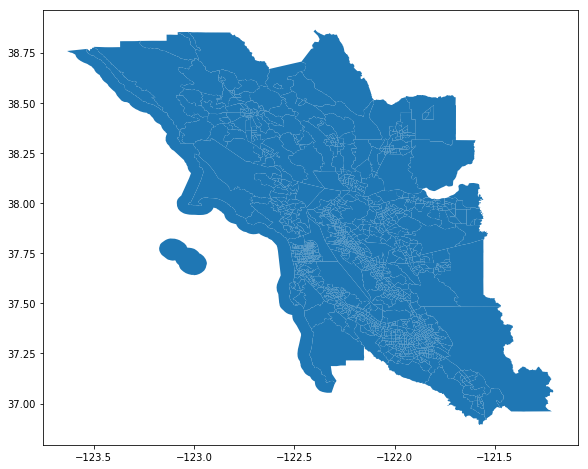

In [50]:
tracts.plot()

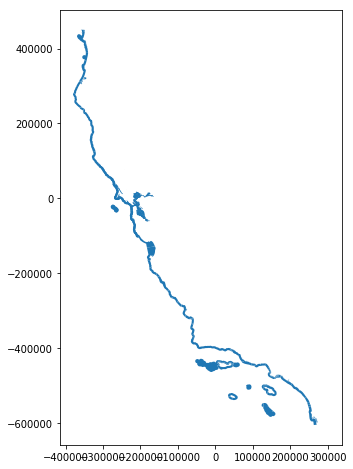

In [52]:
ocean = gpd.read_file('data/California_coast/California_coast.shp')
ocean.plot()

# 4. Gini coefficient 

Gini index is used mainly for income distribution. It's a number
ranging from 0 to 1, where 0 indicates perfect income equality
in the measured population and 1 indicates perfect inequality in
the measured population. In order to compute a Gini index, we
draw a graph that plots the bottom x percent of income earners
in a population against the percent of the income (from all
available income) that the group has earned.
we could compute a Gini index in which we omit the
top 5% of income earners in each population. As a result, our
study would consider income distribution in the bulk of a population
without the skewed effect of high-income outliers. 

# Second Dimention| ISOLATION***************************************

# 1. Isolation Index

In [45]:
def isolation(df, bi,B, T):
    df['isolation'] = (
        ((df[bi]/df[B])*(df[bi]/df[T])))
    return (df['isolation'].sum())

# T is total number of households in region

## Black

In [46]:
isolation = [
    (df, 'black_bl', 'black_region', 'black_bl', 'total_hh_region'),
    (df_rm,'black_bl', 'black_region', 'black_bl', 'total_hh_region')
]

for pop in isolation:
    print (dissimilarity(*pop))

0.4682213308702691
0.463821636530858


## Asian

In [47]:
isolation = [
    (df, 'asian_bl', 'asian_region', 'asian_bl', 'total_hh_region'),
    (df_rm,'asian_bl', 'asian_region', 'asian_bl', 'total_hh_region')
]

for pop in isolation:
    print (dissimilarity(*pop))

0.3964842334593825
0.3801486362244488


## White 

In [48]:
isolation = [
    (df, 'white_bl', 'white_region', 'white_bl', 'total_hh_region'),
    (df_rm,'white_bl', 'white_region', 'white_bl', 'total_hh_region')
]

for pop in isolation:
    print (dissimilarity(*pop))

0.17885386746973927
0.21104702070841805


# 2. Interaction or Exposure Index 

In [49]:
def interaction(df, bi,B,nbi, Ti):
    df['interaction'] = (
        ((df[bi]/df[B])*(df[nbi]/df[Ti])))
    return (df['interaction'].sum())

# Ti is total number of households in tract

## Black

In [50]:
print (interaction(df, 'black_bl', 'black_region', 'non_black_bl', 'total_hh_bl'))
print (interaction(df_rm, 'black_bl', 'black_region', 'non_black_bl', 'total_hh_bl'))



0.7048912540211176
0.6318124804272013


## Asian

In [51]:
print (interaction(df, 'asian_bl', 'asian_region', 'non_asian_bl', 'total_hh_bl'))
print (interaction(df_rm, 'asian_bl', 'asian_region', 'non_asian_bl', 'total_hh_bl'))


0.604375227701388
0.501370622470573


## White

In [52]:
print (interaction(df, 'white_bl', 'white_region', 'non_white_bl', 'total_hh_bl'))
print (interaction(df_rm, 'white_bl', 'white_region', 'non_white_bl', 'total_hh_bl'))


0.26998655578125536
0.2867707142743789


# Interpretation
    


• The probability of a Black person “interacting” with a non black person is about70%. We can also interpret this to mean that 70 of every 100 people a Black person meets will be non-black.
• Most interaction indexes are not “symmetrical” - the probability of a “typical” Black person meeting a White person is NOT the same as the probability of a “typical” White person meeting a Black one.
• The maximum value of B depends both on the distribution of ethnic groups AND on the proportion of minorities in the city.
• Generally speaking, the value of this index will be highest when the two groups have equal numbers and are spread evenly among tracts.

### Get the csv output for mapping LQ in other notebook

In [53]:
df_black.to_csv('lq_black_1.csv',encoding='utf-8')